# 1. Import libraries

In [3]:
# Import necessary libraries
import os
import sys

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if "google.colab" in sys.modules:
    from google.colab import drive
else:
    print("Not running in Google Colab. Google Drive access will be skipped.")

import numpy as np

# From here, add any libraries that you might need for the rest of your code

2024-09-23 23:44:07.820899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Not running in Google Colab. Google Drive access will be skipped.


# 2. Load and pre-process the dataset

In [4]:
data_dir = ""

if "google.colab" in sys.modules:
    drive.mount("/content/drive")
    print("Google Drive mounted")
else:
    print("Google Drive access is skipped. Load local files instead.")
    data_dir = "./archive"
    
    

Google Drive access is skipped. Load local files instead.


In [5]:
# Set the paths based on your Drive directory
if data_dir == "":
    data_dir ="/content/drive/MyDrive/Deep_Learning_Fall24/Assignment/brain_tumor_dataset" # Change to the path to your directory
train_images_dir = os.path.join(data_dir, "Training")
test_images_dir = os.path.join(data_dir, "Testing")

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: ./archive
Training directory: ./archive/Training
Testing directory: ./archive/Testing


In [6]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        color_mode="grayscale"
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
        color_mode="grayscale"
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

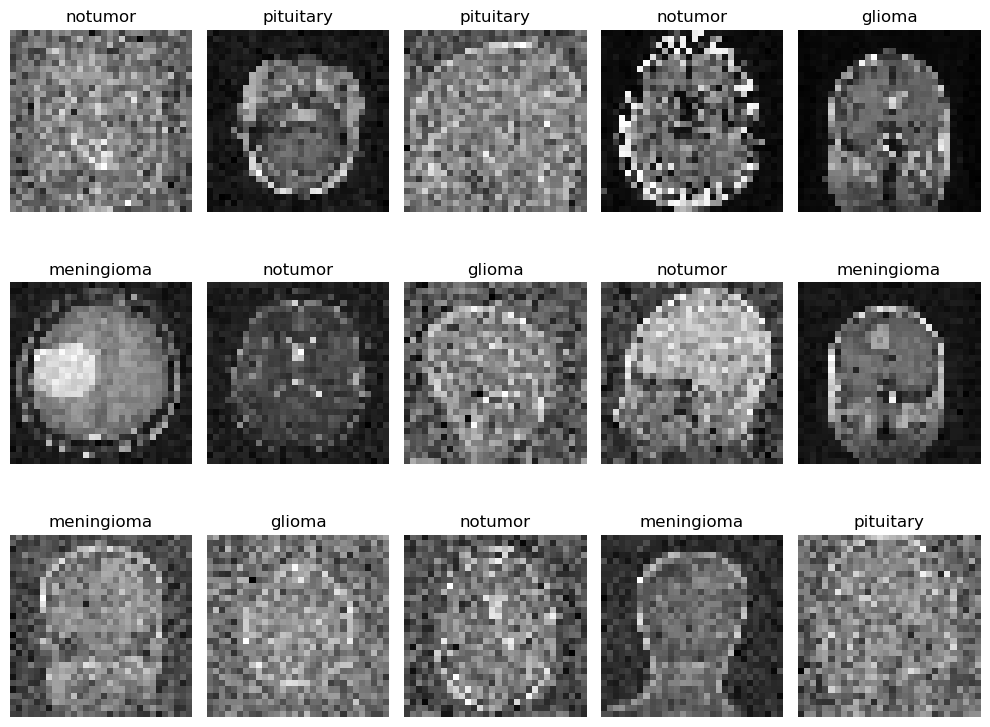

In [125]:
# Randomly select 15 samples from the dataset
import matplotlib.pyplot as plt

# A function to locate an image at the index by calculating relative indices
def get_image_n_label(index):
    batch_index = index // train_data.batch_size
    item_index = index % train_data.batch_size
    
    images, labels = train_data.__getitem__(batch_index)
    return images[item_index], labels[item_index]

# A function to retrieve textual class names by inverting key-value pairs
def get_class_keys():
    class_keys = [""] * len(train_data.classes)

    # The class_indices items object is a dictionary
    for key, value in train_data.class_indices.items():
        class_keys[value] = key
        
    return class_keys
    
try:
    # Randomly generate 15 integers within the train_data index range
    indices = np.random.choice(train_data.samples, 15, replace=False)
    
    # Select 15 images with labels per the random indicies
    random_images, random_labels = zip(*[get_image_n_label(i) for i in indices])
except Exception as e:
    print(f"Error randomly selecting 15 images: {e}")
    raise

try:
    fig, axes = plt.subplots(3, 5, figsize=(10, 8))

    # Flatten the axes for easy access
    axes = axes.flatten()
    
    labels = get_class_keys()
    
    # Display each image with its label
    for i, ax in enumerate(axes):
        image = random_images[i].squeeze()  # Remove channel axis if grayscale
        label_index = np.argmax(random_labels[i])  # Convert one-hot-coding to class index
        label = labels[label_index]
        
        ax.imshow(image, cmap="gray")  # Use grayscale
        ax.set_title(label)
        ax.axis("off")  # Hide axis

    plt.tight_layout() # Make sure the plotting doesn't overlap
    plt.show()
except Exception as e:
    print(f"Error plotting images: {e}")
    raise



Create a bar plot to visualize the class label distribution of the dataset. (Hint: this bar plot reveals how many samples the dataset has for each class)

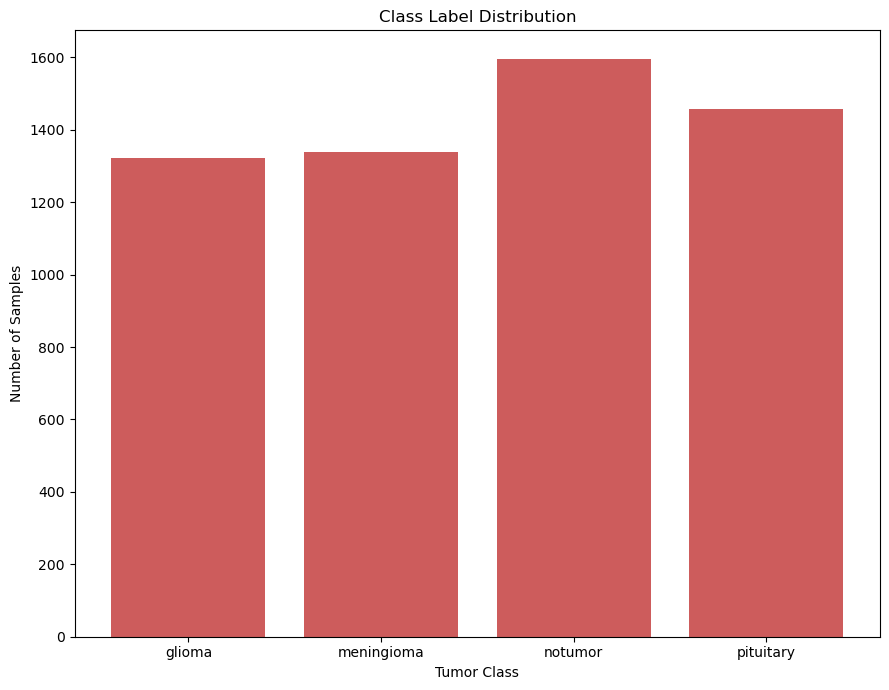

In [118]:
try:
    class_labels = get_class_keys()
    
    # Count the number of samples per class
    class_counts = np.bincount(train_data.classes)
    
    plt.figure(figsize=(9, 7))
    plt.bar(range(len(class_counts)), class_counts, color="indianred")

    # Add class names as the x axis label
    plt.xticks(range(len(class_counts)), [class_labels[i] for i in range(len(class_counts))])
    plt.xlabel("Tumor Class")
    plt.ylabel("Number of Samples")
    plt.title("Class Label Distribution")

    plt.tight_layout() # Make sure the plotting doesn't overlap
    plt.show()

except Exception as e:
    print(f"Error plotting images: {e}")
    raise

Apply 20% of the training set as a validation set to validate the hyperparameters that you have chosen

In [174]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import NumpyArrayIterator

# Apply 20% of the training set as a validation set
train_indices = np.arange(train_data.samples) # Get the range of all samples
train_labels = train_data.classes # Get all the class labels

# Split the indices into indices for training and validation (20%)
train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, stratify=train_labels)

# The function for getting a subset of the training data
def subset_generator(indices):
    while True:
        batch_indices = np.random.choice(indices, size=32)
        images, labels = [], []
        
        images, labels = zip(*[get_image_n_label(i) for i in batch_indices])
        yield np.array(images), np.array(labels)

def get_subset_data(indices):
    images, labels = [], []
    for i in indices:
        image, label = get_image_n_label(i)
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

train_generator = subset_generator(train_indices)
valid_generator = subset_generator(valid_indices)

# Create two sub generators for training (80% indices) and validation (20% indices)
# x_train, y_train = get_subset_data(train_indices)
# x_valid, y_valid = get_subset_data(valid_indices)

# datagen = ImageDataGenerator()
# # Now create NumpyArrayIterator for training and validation
# train_iterator = NumpyArrayIterator(x_train, y_train, datagen, batch_size=32)
# valid_iterator = NumpyArrayIterator(x_valid, y_valid, datagen, batch_size=32)

# print(train_generator)
# print(next(train_generator))

Implement the baseline CNN algorithm (exactly, without any modification for both model and dataset) that is shown in Fig. 1. It is a network consisting of: 
a Convolutional layer with 32 filters and kernel size of 3 × 3 with ReLU activations that is followed by a max pooling layer of size 2 × 2 and again a 
convolutional layer of 32 filters of size 3 × 3 with ReLU activations. Each convolutional layer is followed by a MaxPooling layer with a size of 2 × 2. 
Finally, a dense layers of sizes 32 and with Relu

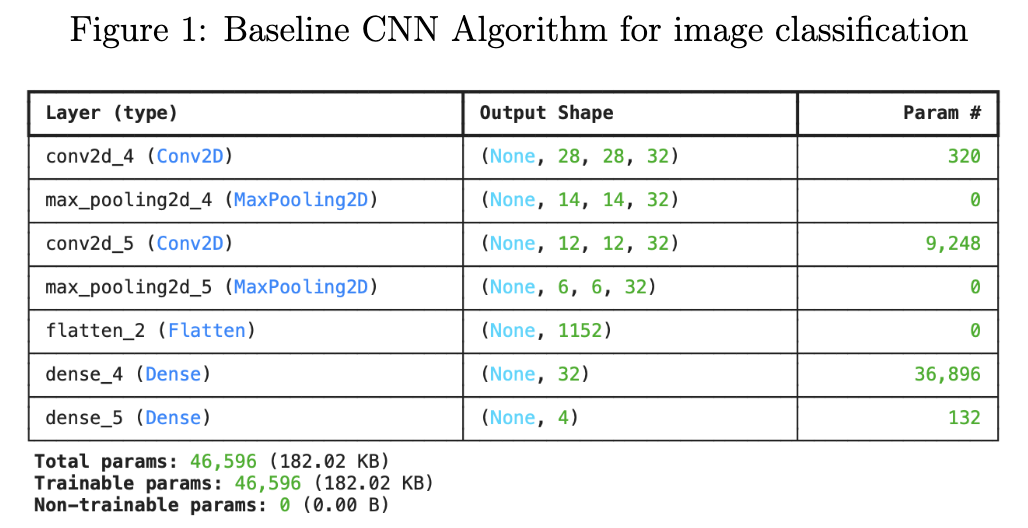

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 1152)              0         
                                                                 
 dense_13 (Dense)            (None, 32)               

# 4. Train and Evaluation functions

In [168]:
from tensorflow.keras.utils import to_categorical

def get_training_array(train_data):
    train_data.reset()  # Reset the iterator if needed
    
    # Initialize lists to hold the images and labels
    image_array = []
    label_array = []
    
    # Iterate over the entire dataset
    for i in range(len(train_data)):
        images, labels = train_data.next()  # Get the next batch of images and labels
        image_array.append(images)
        label_array.append(labels)

    # Convert the lists to NumPy arrays
    x_train = np.concatenate(image_array, axis=0)  # Concatenate batches into a single array
    y_train = np.concatenate(label_array, axis=0)  # Concatenate labels
    # Convert target values (class labels) into one-hot encoding
    y_train = to_categorical(y_train, num_classes=train_data.num_classes)
    
    return x_train, y_train


In [36]:
print(train_data)
data_set = train_data.image_data_generator
print(data_set)

train_data.reset()
X_train, y_train = next(train_data)
for i in range(int(train_data.samples/32) - 1): 
  img, label = next(train_data)
  X_train = np.append(X_train, img, axis=0)
  y_train = np.append(y_train, label, axis=0)
  
print(X_train.shape, y_train.shape)


(5696, 30, 30, 1) (5696, 4)


In [32]:
print((5696/32)*0.8)

142.4


In [22]:
from tensorflow.keras import layers, models

baseline_model = models.Sequential()

# The 1st Convolutional layer with 32 filters (with padding='same' to preserve the input dimensions)
baseline_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)))

# The 1st MaxPooling layer of size 2 x 2
baseline_model.add(layers.MaxPooling2D((2, 2)))

# The 2nd Convolutional layer with 32 filters
baseline_model.add(layers.Conv2D(32, (3, 3), activation='relu'))

# The 2nd MaxPooling layer of size 2 x 2
baseline_model.add(layers.MaxPooling2D((2, 2)))

# The flatten layer
baseline_model.add(layers.Flatten())

# The 1st Dense (fully connected) layer of size 32
baseline_model.add(layers.Dense(32, activation='relu'))

# The output layer with 4 units for 4-class classification
baseline_model.add(layers.Dense(4, activation='softmax'))

baseline_model.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summarize the baseline model
baseline_model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
                                                                 
 dense_6 (Dense)             (None, 32)               

# 5. Model training

In [33]:
history = baseline_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    shuffle=True,
    validation_split=0.2,
    validation_batch_size = 32
)

Epoch 1/10
143/143 [==============================] - 2s 15ms/step - loss: 0.0114 - accuracy: 0.9996 - val_loss: 0.4356 - val_accuracy: 0.8675
Epoch 2/10
143/143 [==============================] - 2s 15ms/step - loss: 0.0086 - accuracy: 0.9998 - val_loss: 0.4441 - val_accuracy: 0.8702
Epoch 3/10
143/143 [==============================] - 2s 16ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.4749 - val_accuracy: 0.8702
Epoch 4/10
143/143 [==============================] - 2s 16ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.4681 - val_accuracy: 0.8772
Epoch 5/10
143/143 [==============================] - 2s 17ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.4691 - val_accuracy: 0.8772
Epoch 6/10
143/143 [==============================] - 3s 18ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.4959 - val_accuracy: 0.8746
Epoch 7/10
143/143 [==============================] - 3s 20ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4893 - val_accuracy: 0.8789

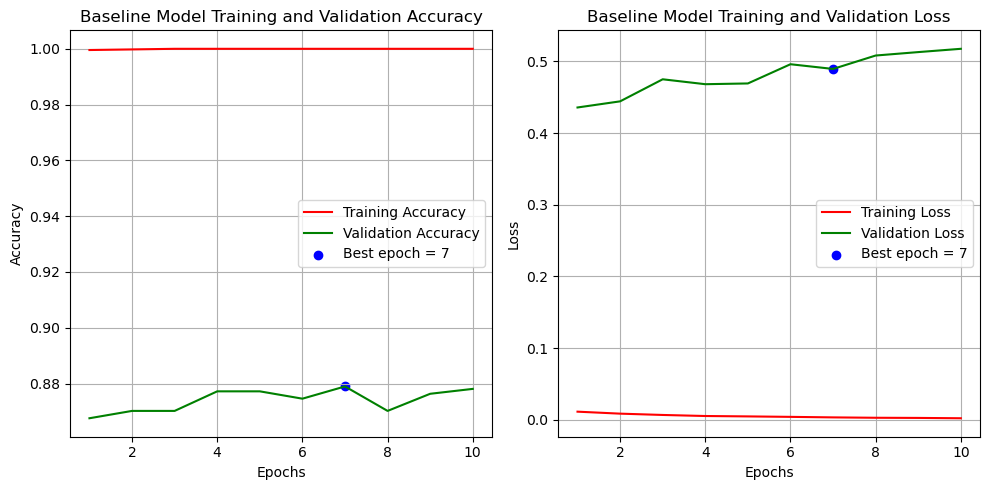

In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'g', label='Validation Accuracy')
    plt.title('Baseline Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation accuracy
    best_epoch_acc = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
    plt.scatter(best_epoch_acc, max(history.history['val_accuracy']), label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'g', label='Validation Loss')
    plt.title('Baseline Model Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation loss based on the best validation accuracy epoch
    plt.scatter(best_epoch_acc, history.history['val_loss'][best_epoch_acc - 1], label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the history object returned from model.fit()
plot_training_history(history)
     

In [23]:
from tensorflow.keras.utils import to_categorical

# x_train, y_train = get_training_array(train_data)

# Train the model using the generators
# history = baseline_model.fit(
#     x_train,
#     y_train,
#     steps_per_epoch=train_data.samples // train_data.batch_size,
#     epochs=1,
#     validation_split=0.2
# )

history = baseline_model.fit(
    train_generator,
    batch_size=32,
    epochs=1,
    validation_data=valid_generator
)

NameError: name 'train_generator' is not defined

AttributeError: 'generator' object has no attribute 'shape'

# 6. Model evaluation